In [1]:
import os
import torch
import datasets.paths as d_path
import torchvision

from tv_ref.engine import train_one_epoch, evaluate
from utils.init import reproducibility, clean_memory_get_device
from config import ConfigArgs
from utils.train import EarlyStopper, TrainingInfo, epoch_end_print, get_dataloaders, get_datasets
from torchvision.models import ResNet50_Weights
from utils.plot import plot_losses
from IPython.display import clear_output
from tv_custom.faster_rcnn import fasterrcnn_resnet50_fpn

import warnings
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
device = clean_memory_get_device()
# device = torch.device("cpu")
reproducibility()
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

In [3]:
from config.dataset import REFLACXLesionDetectionDatasetArgs
from config.model import FasterRCNNArgs
from config.training import LesionDetectionArgs

training_args = LesionDetectionArgs(
    name="lesion_detection",
    batch_size=4,
)
dataset_args = REFLACXLesionDetectionDatasetArgs(
    image_size=128,
)

cl_model_name = "MCL_resnet50_accuracy_0_0600_epoch1_10-03-2023 00-10-45"

configs = [
    ConfigArgs(
        training=training_args,
        dataset=dataset_args,
        model=FasterRCNNArgs(
            name="CL_NoFix",
            weights="cl",
            cl_model_name=cl_model_name,
            trainable_backbone_layers=5,
        )
    ),
    ConfigArgs(
        training=training_args,
        dataset=dataset_args,
        model=FasterRCNNArgs(
            name="CL_Fix0",
            weights="cl",
            cl_model_name=cl_model_name,
            trainable_backbone_layers=0,
        )
    ),
    ConfigArgs(
        training=training_args,
        dataset=dataset_args,
        model=FasterRCNNArgs(
            name="CL_Fix2",
            weights="cl",
            cl_model_name=cl_model_name,
            trainable_backbone_layers=3,
        )
    ),
    ConfigArgs(
        training=training_args,
        dataset=dataset_args,
        model=FasterRCNNArgs(
            name="imagenet",
            weights="imagenet",
            trainable_backbone_layers=3,
        )
    ),
    ConfigArgs(
        training=training_args,
        dataset=dataset_args,
        model=FasterRCNNArgs(
            name="random",
            weights=None,
            trainable_backbone_layers=5,
        )
    ),
]

In [4]:
num_epochs = 5  # 200
train_infos: list[TrainingInfo] = []

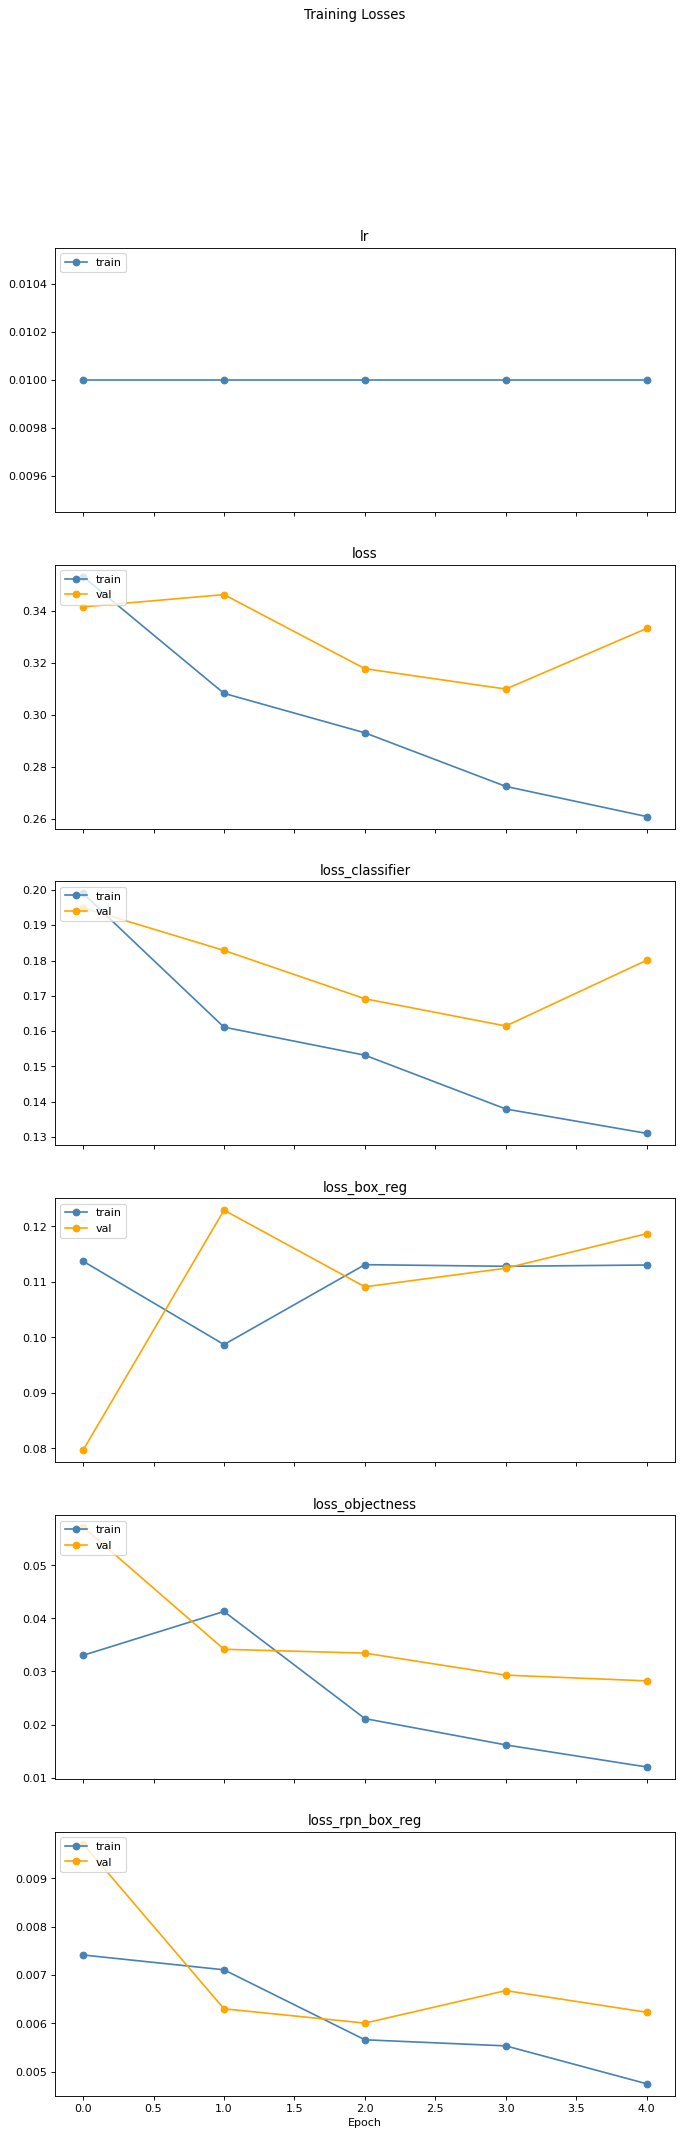

| Epoch [5] Done | It has took [18.03] min, Avg time: [216.30] sec/epoch | Estimate time for [5] epochs: [18.03] min | Epoch took [214.849595] sec |  Patience [0] |
| Training Done, start testing! | [5] Epochs Training time: [1081.516844] seconds, Avg time / Epoch: [216.3033688] seconds
========================================For Training [lesion_detection]========================================
LesionDetectionArgs(name='lesion_detection', learning_rate=0.01, sgd_momentum=0.9, batch_size=4, weight_decay=1e-05, early_stopping_patience=10, warmup_epoch=0)
REFLACXLesionDetectionDatasetArgs(image_size=128, label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'])
FasterRCNNArgs(name='CL_NoFix', weights='cl', cl_model_name='MCL_resnet50_accuracy_0_0600_epoch1_10-03-2023 00-10-45', trainable_backbone_layers=5)

Best model has been saved to: [lesion_detection_CL_NoFix_ap_0_1275_ar_0_3221_epoch4_10-03-2023 02-33-01]
The final model h

In [5]:
from datasets.reflacx.lesion_detection import REFLACXLesionDetectionDataset
from engine.lesion_detection import check_best, end_train, load_cl_pretrained
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
for config in configs:
    # device = clean_memory_get_device()
    # reproducibility()

    train_info = TrainingInfo(config)

    if config.model.weights == 'imagenet':
        weights_backbone = ResNet50_Weights.IMAGENET1K_V2
        trainable_backbone_layers = config.model.trainable_backbone_layers
    else:
        weights_backbone = None
        trainable_backbone_layers = None

    model = fasterrcnn_resnet50_fpn(
        # weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1
        weights_backbone=weights_backbone,
        trainable_backbone_layers=trainable_backbone_layers,
    )
    model.to(device)
    # load CL weights.

    if config.model.weights == 'cl':
        model = load_cl_pretrained(
            model,
            config.model.cl_model_name,
            config.model.trainable_backbone_layers,
        )

    dataset_args = {
        "df_path": os.path.join('spreadsheets', "reflacx.csv"),
        "mimic_eye_path": d_path.MIMIC_EYE_PATH,
        "image_size": config.dataset.image_size,
        "label_cols": config.dataset.label_cols,
    }

    train_dataset, val_dataset, _ = get_datasets(
        dataset_args=dataset_args,
        dataset_class=REFLACXLesionDetectionDataset,
    )

    train_dataloader, val_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        batch_size=config.training.batch_size,
        drop_last=False,
    )

    optimiser = torch.optim.SGD(
        params=[p for p in model.parameters() if p.requires_grad],
        lr=config.training.learning_rate,
        momentum=config.training.sgd_momentum,
        weight_decay=config.training.weight_decay,
    )

    early_stopper = None
    if config.training.early_stopping_patience:
        early_stopper = EarlyStopper(
            patience=config.training.early_stopping_patience)

    train_info.timer.start_training()

    for e in range(1, num_epochs + 1):
        train_info.epoch = e
        train_info.timer.start_epoch()
        print(train_info)

        train_logger = train_one_epoch(
            model=model,
            optimiser=optimiser,
            data_loader=train_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
        )

        train_info.train_losses.append(train_logger.get_data())
        model.eval()


        val_logger, val_evaluator = evaluate(
            model=model,
            data_loader=val_dataloader,
            device=device,
            return_evaluator=True,
        )

        train_info.val_losses.append(val_logger.get_data())
        clear_output()
        plot_losses(
            train_info.train_losses,
            train_info.val_losses,
        )
        epoch_end_print(train_info, early_stopper, num_epochs)

        if early_stopper and train_info.epoch > config.training.warmup_epoch:
            train_info = check_best(
                train_info=train_info,
                model=model,
                optimiser=optimiser,
                val_evaluator=val_evaluator,
            )
            to_stop = early_stopper.early_stop(
                train_info.val_losses[-1]['loss'])
            if to_stop:
                print(
                    f"| Patience reached [{early_stopper.counter}], EarlyStopping end |")
                break

    train_info = end_train(
        train_info=train_info,
        model=model,
        optimiser=optimiser,
        val_evaluator=val_evaluator,
    )

    train_infos.append(train_info)

========================================For Training [lesion_detection]========================================
LesionDetectionArgs(name='lesion_detection', learning_rate=0.01, sgd_momentum=0.9, batch_size=4, weight_decay=1e-05, early_stopping_patience=10, warmup_epoch=0)
REFLACXLesionDetectionDatasetArgs(image_size=128, label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'])
FasterRCNNArgs(name='CL_NoFix', weights='cl', cl_model_name='MCL_resnet50_accuracy_0_0600_epoch1_10-03-2023 00-10-45', trainable_backbone_layers=5)

Best model has been saved to: [lesion_detection_CL_NoFix_ap_0_1275_ar_0_3221_epoch4_10-03-2023 02-33-01]
The final model has been saved to: [lesion_detection_CL_NoFix_ap_0_0635_ar_0_3199_epoch5_10-03-2023 02-36-36]



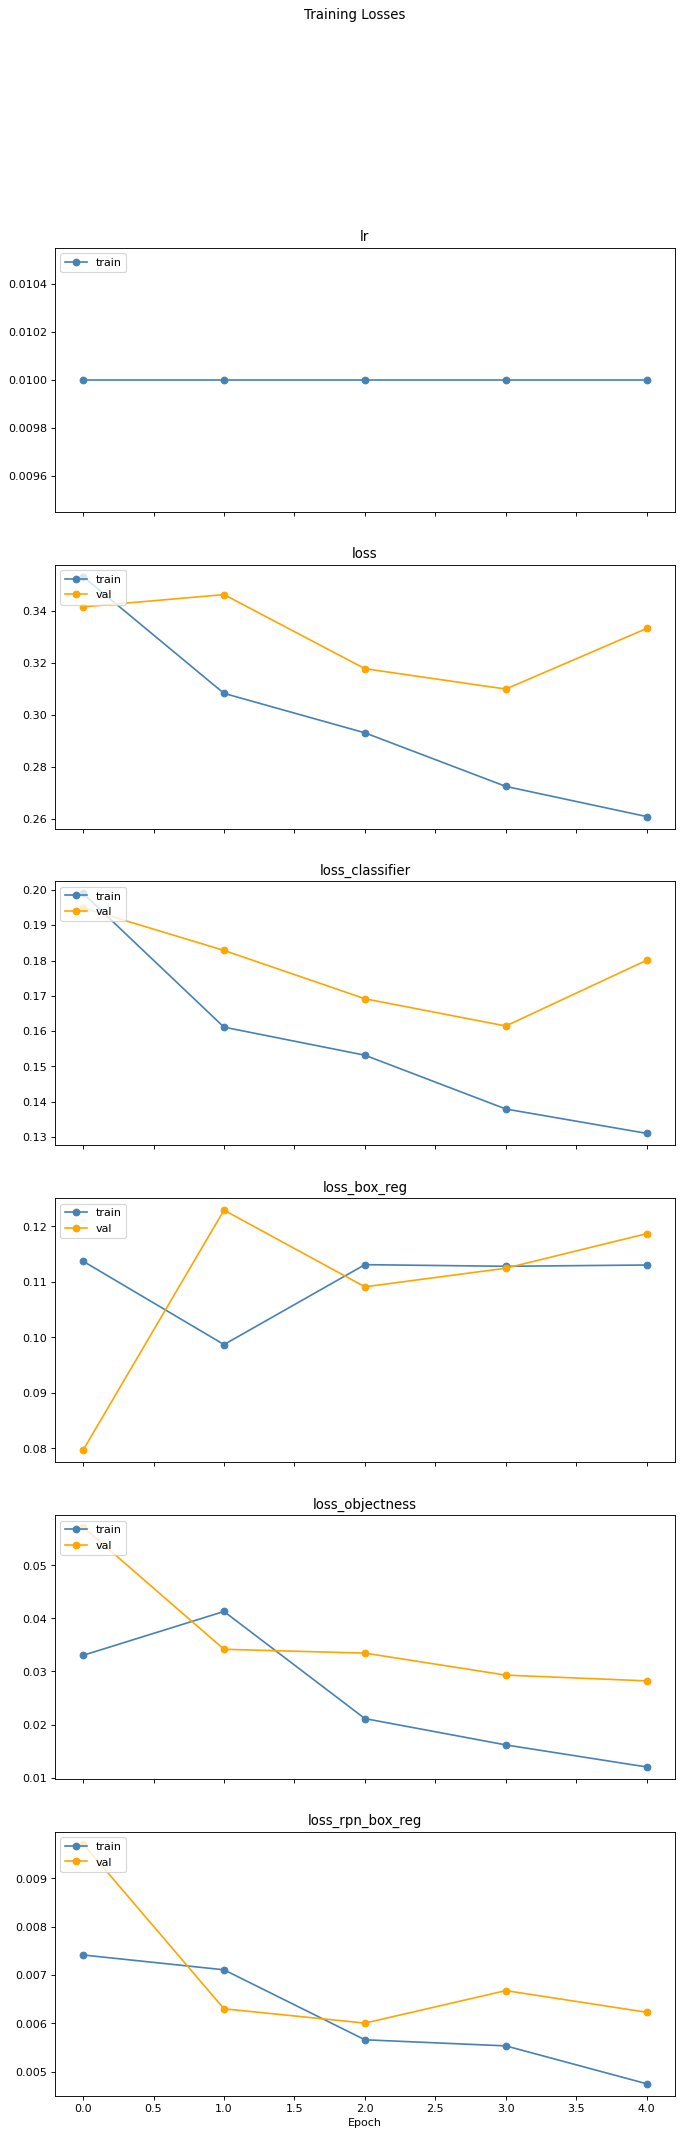

In [6]:
for t in train_infos :
    print(t)
    plot_losses(
        t.train_losses,
        t.val_losses,
    )

In [7]:
# Evaluate all train_infos on the best
from utils.checkpoint import load_checkpoints
from engine.lesion_detection import get_ap_ar

for t in train_infos:

    train_info, cp = load_checkpoints(t.best_val_loss_model_path, device)
    config = train_info.config
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        weights=None,
    )
    model.to(device)
    model.load_state_dict(cp["model"])
    model.eval()

    dataset_args = {
        "df_path": os.path.join('spreadsheets', "reflacx.csv"),
        "mimic_eye_path": d_path.MIMIC_EYE_PATH,
        "image_size": config.dataset.image_size,
        "label_cols": config.dataset.label_cols,
    }

    _, _, test_dataset = get_datasets(
        dataset_args=dataset_args,
        dataset_class=REFLACXLesionDetectionDataset,
    )

    _, _, test_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        test_dataset,
        batch_size=config.training.batch_size,
        drop_last=False,
    )

    _, test_evaluator = evaluate(
        model=model,
        data_loader=test_dataloader,
        device=device,
        return_evaluator=True,
    )

    performance_dict = get_ap_ar(
        val_evaluator.coco_eval["bbox"],
    )

    print(t)
    print(performance_dict)

    with open(os.path.join('checkpoints', t.best_val_loss_model_path, 'performance.txt'), 'w') as f:
        f.write(str(t) + "\n" + "Best: \n" + str(performance_dict))

creating index...
index created!
Test:  [ 0/13]  eta: 0:02:06  model_time: 9.5148 (9.5148)  evaluator_time: 0.0020 (0.0020)  loss: 0.1109 (0.1109)  loss_classifier: 0.0689 (0.0689)  loss_box_reg: 0.0367 (0.0367)  loss_objectness: 0.0045 (0.0045)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 9.7065  data: 0.1897  max mem: 0
Test:  [12/13]  eta: 0:00:09  model_time: 9.6581 (9.4615)  evaluator_time: 0.0023 (0.0025)  loss: 0.3641 (0.3654)  loss_classifier: 0.1556 (0.1809)  loss_box_reg: 0.1144 (0.1340)  loss_objectness: 0.0238 (0.0405)  loss_rpn_box_reg: 0.0117 (0.0101)  time: 9.6541  data: 0.1901  max mem: 0
Test: Total time: 0:02:05 (9.6542 s / it)
Averaged stats: model_time: 9.6581 (9.4615)  evaluator_time: 0.0023 (0.0025)  loss: 0.3641 (0.3654)  loss_classifier: 0.1556 (0.1809)  loss_box_reg: 0.1144 (0.1340)  loss_objectness: 0.0238 (0.0405)  loss_rpn_box_reg: 0.0117 (0.0101)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50      | are